In [55]:
import os
import cv2
import numpy as np
os.chdir('/home/mckc/clustering/')
from PIL import Image
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

In [56]:
from cv2 import resize
from skimage import exposure
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

selem = disk(30)
size = []
images_geq = []
images_eql = []
images = []
files = os.listdir('/home/mckc/clustering/')
for i in files:
    image = resize(cv2.imread(i,0),(96,96))
    #image = cv2.imread(i,0)
        # Global equalize
    image_g_eq = exposure.equalize_hist(image)

    # Equalization
    image_eql = rank.equalize(image, selem=selem)
    images.append(image)
    images_geq.append(image_g_eq)
    images_eql.append(image_eql)
    size.append(image.shape[0])
size = np.array(size)
image_data = np.array(images).reshape(-1,9216)
images_geq = np.array(images_geq).reshape(-1,9216)
images_eql = np.array(images_eql).reshape(-1,9216)

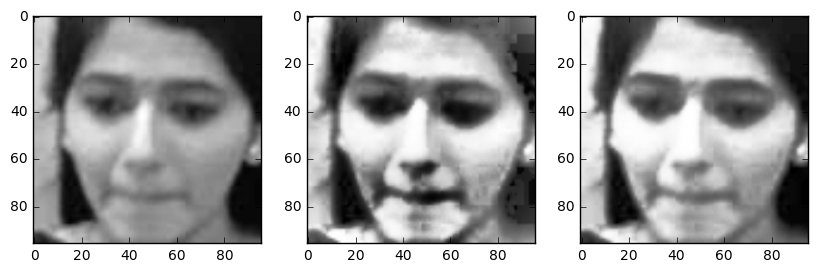

In [35]:
%matplotlib inline

index = 243
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(image_data[index].reshape(96,96),cmap=cm.Greys_r)

fig.add_subplot(1,3,2)
plt.imshow(images_eql[index].reshape(96,96),cmap=cm.Greys_r)

fig.add_subplot(1,3,3)
plt.imshow(images_geq[index].reshape(96,96),cmap=cm.Greys_r)
plt.show()


In [36]:
gray = image_data[index].reshape(96,96)
cv2.Laplacian(gray, cv2.CV_64F).var()

25.987180309531126

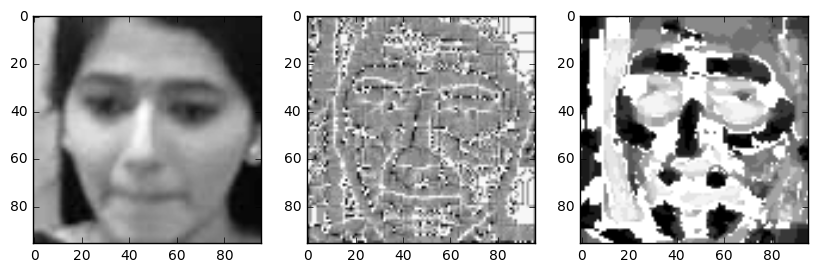

In [37]:
from skimage.feature import local_binary_pattern
# settings for LBP
radius = 1 #1
n_points = 16#  3* radius 
LBP1 = local_binary_pattern(gray,n_points,radius,'uniform')

radius = 10
n_points = 1 * radius 
LBP2 = local_binary_pattern(gray,n_points,radius,'uniform')


#plt.figure(1)
fig = plt.figure(figsize=(10,10))

fig.add_subplot(1,3,1)
plt.imshow(gray,cmap=cm.Greys_r)

fig.add_subplot(1,3,2)
plt.imshow(LBP1,cmap=cm.Greys_r)

fig.add_subplot(1,3,3)
plt.imshow(LBP2,cmap=cm.Greys_r)
plt.show()

In [57]:
n_components = 150

h,w = 96,96

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, image_data.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(images_geq)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X = pca.transform(images_geq)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 7174 faces
done in 5.480s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.360s


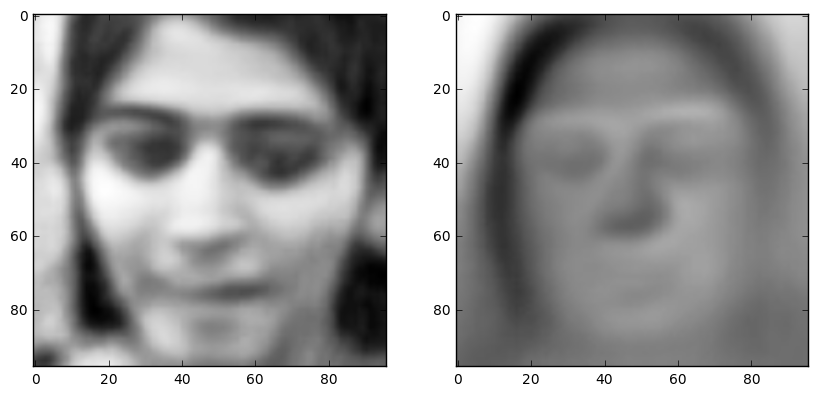

In [40]:
A = pca.inverse_transform(X[243])

fig = plt.figure(figsize=(10,10))

fig.add_subplot(1,2,1)
plt.imshow(A.reshape(96,96),cmap=cm.Greys_r)

fig.add_subplot(1,2,2)
plt.imshow(eigenfaces[4],cmap=cm.Greys_r)


In [48]:
def thresholded(center, pixels):
    out = []
    for a in pixels:
        if a >= center:
            out.append(1)
        else:
            out.append(0)
    return out

def get_pixel_else_0(l, idx, idy, default=0):
    try:
        return l[idx,idy]
    except IndexError:
        return default

In [ ]:
for x in range(0, len(img)):
    for y in range(0, len(img[0])):
        center        = img[x,y]
        top_left      = get_pixel_else_0(img, x-1, y-1)
        top_up        = get_pixel_else_0(img, x, y-1)
        top_right     = get_pixel_else_0(img, x+1, y-1)
        right         = get_pixel_else_0(img, x+1, y )
        left          = get_pixel_else_0(img, x-1, y )
        bottom_left   = get_pixel_else_0(img, x-1, y+1)
        bottom_right  = get_pixel_else_0(img, x+1, y+1)
        bottom_down   = get_pixel_else_0(img, x,   y+1 )

        values = thresholded(center, [top_left, top_up, top_right, right, bottom_right,
                                      bottom_down, bottom_left, left])

        weights = [1, 2, 4, 8, 16, 32, 64, 128]
        res = 0
        for a in range(0, len(values)):
            res += weights[a] * values[a]

        transformed_img.itemset((x,y), res)

print x

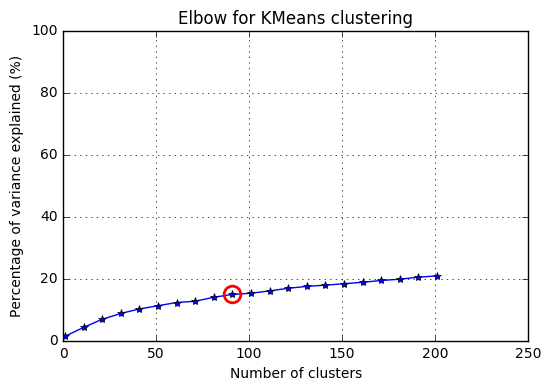

In [41]:
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist

##### cluster data into K=1..20 clusters #####
K_MAX = 200
KK = range(1,K_MAX+10,10)

KM = [kmeans(X[:,2:],k,iter=400) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X[:,2:], cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss      

##### plots #####
kIdx = 9        # K=10
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, betweenss/totss*100, 'b*-')
ax.plot(KK[kIdx], betweenss[kIdx]/totss*100, marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')

In [58]:
from sklearn.cluster import KMeans
clusters = KMeans( n_clusters=100, n_init=10,n_jobs=-1,max_iter =500).fit_predict(X[:,:])

In [59]:
for i in range(len(clusters)):
     os.rename(files[i],str(clusters[i])+'_'+str(i)+'.jpg')

In [ ]:
print ('Attempt to identify the faces using the SVD  from the image')

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=95, random_state=42)
svd_values = np.zeros((1,95))
for i in range(len(images_geq)):
    svd.fit(images_geq) 
    svd_values = np.vstack((svd_values,svd.explained_variance_ratio_.reshape(1,95)))
svd_values = svd_values[1:,:]

data_dist = pdist(svd_values[:30,:]) # computing the distance
data_link = linkage(data_dist) # computing the linkage

dendrogram(data_link,labels=svd_values[:30,:].dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=15);

Attempt to identify the faces using the SVD  from the image


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=150)
X_lda_sklearn = sklearn_lda.fit_transform(faces, labels)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
sklearn_qda = QDA(n_components=150)
X_qda_sklearn = sklearn_qda.fit_transform(faces, labels)

OSError: [Errno 2] No such file or directory